In [7]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
### Loading the data
path_df1_images_resized = "/home/vvdiaz1/code/vvdiaz1/automatic_tagging/notebooks/df1"
path_df1_csv = "/home/vvdiaz1/code/vvdiaz1/automatic_tagging/raw_data/df1.csv"
## We load the df1 csv file into a Pandas Dataframe
df_1=pd.read_csv(path_df1_csv, error_bad_lines = False)

## Now we have to create the filenames for each one of the images in the df1 folder
list_id = list(df_1.id)
images = []
for file in list_id:
    images.append(str(file) + ".jpg")
filenames = []
for image in images:
    filenames.append((os.path.join(path_df1_images_resized, image)))
    
batch_size = 128
images = []

for i in range(0, len(filenames), batch_size):
    batch_filenames = filenames[i:i+batch_size]
    images_batch = [np.array(Image.open(image_filename)) for image_filename in batch_filenames]
    images.extend(images_batch)

/tmp/ipykernel_511/3327146404.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_1=pd.read_csv(path_df1_csv, error_bad_lines = False)


,Unnamed: 0.1,Unnamed: 0,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,0,0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,1,1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,2,2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,3,3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,4,4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,19997,18883,Women,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Arrow Woman Payton Navy Blue Shirt
19996,19996,19998,34275,Women,Apparel,Topwear,Dupatta,Off White,Summer,2012.0,Ethnic,Fabindia Women Printed Off White Dupatta
19997,19997,19999,7572,Men,Apparel,Topwear,Tshirts,Orange,Summer,2011.0,Sports,Nike Men's As Miler UV SS Orange T-shirt
19998,19998,20000,19951,Unisex,Accessories,Headwear,Caps,Navy Blue,Fall,2011.0,Casual,Puma Unisex Cat Logo Navy Blue Cap


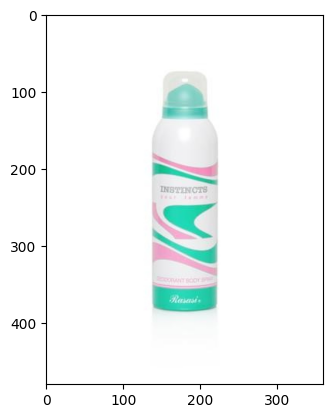

In [9]:
X = images  ## Now the images are loaded
plt.imshow(X[19999])
df_1

In [ ]:
### Now we have to load the target variable

In [ ]:
#para el modelo 1 estas son las labels = masterCategory
labels1 = np.unique(df_1.masterCategory).tolist()
num_cat1 = len(labels1)
print('Categories: ',labels1)
print('Number of categories: ', num_cat1)

#definimos y como el masterCategory y luego los convertimos a int para usar to_categorical
y1 = df_1[['masterCategory']]
y1.masterCategory =pd.Categorical(y1.masterCategory)
y1_num = y1.masterCategory.cat.codes
y1_cat = to_categorical(y1_num,num_cat1)

#revisamos
print(len(y1_cat[0]) == num_cat1)

In [ ]:
def load_own_model():
    model = Sequential()
    model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(7, activation='softmax'))

    model.compile(loss = 'categorical_crossentropy', 
                optimizer = 'adam',
                metrics = 'accuracy')
  
    return model

In [ ]:
model = load_own_model()
history = model.fit(X_train, y_train,validation_data = (X_val, y_val),
                    batch_size = 32, epochs = 500,
                    callbacks = EarlyStopping(patience = 20,restore_best_weights = True),
                    verbose = 1)

In [ ]:
res_1 = model.evaluate(X_test, y_test)

In [ ]:
def load_vgg16():
  model = VGG16(include_top=False,input_shape=X_train.shape[1:])
  return model
model_vgg16 = load_vgg16()
model_vgg16.summary()

In [ ]:
def set_nontrainable_layers(model):
    model.trainable = False
    return model

In [ ]:
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    base_model = set_nontrainable_layers(model)
    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(3, activation='softmax')

    model = Sequential([base_model,
                        flattening_layer,
                        dense_layer,
                        prediction_layer])
    return model